In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

In [21]:
# 设置绘图风格
sns.set(style="whitegrid")

In [22]:
# ==========================================
# 1. 配置区域 (Configuration)
# ==========================================
# 请确保文件名与你下载的一致
FILE_PATH = 'data/processed/TimeBasedFeatures-Dataset-15s-VPN.arff'

In [23]:
# ==========================================
# 2. 数据加载函数 (ARFF Loader)
# ==========================================
def load_arff_data(file_path):
    print(f"📂 [Step 1] 正在读取 ARFF 文件: {file_path} ...")
    try:
        # 读取 ARFF 数据
        data, meta = arff.loadarff(file_path)
        df = pd.DataFrame(data)
        
        # 【关键解码】ARFF中的字符串通常是 byte 格式 (b'String')，需要解码为 utf-8
        str_cols = df.select_dtypes([object]).columns
        for col in str_cols:
            df[col] = df[col].str.decode('utf-8')
            
        print(f"   ✅ 读取成功！数据形状: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"   ❌ 错误: 找不到文件 '{file_path}'。请检查路径是否正确。")
        return None

In [24]:
# ==========================================
# 3. 模型训练与评估 (Modeling)
# ==========================================
def train_and_evaluate(X, y):
    # 3.1 划分训练集和测试集 (80% 训练, 20% 测试)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 3.2 数据标准化 (Scaling) - 虽然随机森林不强制，但对其他模型是必须的，建议保留
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # 3.3 初始化模型 - 随机森林 (Random Forest)
    # n_estimators=100: 100棵树
    # n_jobs=-1: 使用所有 CPU 核心加速
    print("🚀 正在训练随机森林模型 (Random Forest)...")
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # 3.4 预测
    y_pred = clf.predict(X_test)
    
    # 3.5 打印核心指标
    print("\n" + "="*40)
    print("📊 评估报告 (Evaluation Report)")
    print("="*40)
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'VPN']))
    
    return clf, X_test, y_test, y_pred, scaler

In [25]:
# ==========================================
# 3. 数据预处理 (Preprocessing)
# ==========================================
def preprocess_data(df):
    print("\n🧹 [Step 2] 正在进行数据清洗与特征工程...")
    
    # 自动寻找标签列
    target_col = df.columns[-1] 
    print(f"   -> 自动识别标签列为: '{target_col}'")
    
    # 打印原始标签
    unique_labels = df[target_col].unique()
    print(f"   -> 原始标签类别: {unique_labels}")
    
    # === 修复后的标签映射逻辑 ===
    def map_label(label):
        label_str = str(label).lower()
        
        # 1. 先排除 Non-VPN (这是关键修复！)
        if 'non-vpn' in label_str:
            return 0 # Normal
            
        # 2. 再检测 VPN
        if 'vpn' in label_str or 'tor' in label_str:
            return 1 # VPN / Anomaly
            
        # 3. 其他情况默认为 0
        return 0 

    df['Binary_Label'] = df[target_col].apply(map_label)
    
    # 统计分布
    y = df['Binary_Label']
    print(f"   -> 转换后类别分布: Normal(0)={sum(y==0)}, VPN(1)={sum(y==1)}")
    
    if sum(y==0) == 0 or sum(y==1) == 0:
         raise ValueError("❌ 依然只有一种类别！请检查 map_label 函数逻辑。")

    # 特征选择
    cols_to_drop = [target_col, 'Binary_Label']
    X = df.drop(columns=cols_to_drop)
    
    # 清洗数值
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = X.replace([np.inf, -np.inf], 0)
    
    return X, y
    
    def map_label(label):
        label_str = str(label).lower()
        if any(keyword in label_str for keyword in vpn_keywords):
            return 1 # VPN / Anomaly
        return 0 # Normal / Non-VPN

    df['Binary_Label'] = df[target_col].apply(map_label)
    
    # 统计转换后的分布
    y = df['Binary_Label']
    count_normal = sum(y==0)
    count_vpn = sum(y==1)
    print(f"   -> 转换后类别分布: Normal(0)={count_normal}, VPN(1)={count_vpn}")
    
    if count_normal == 0 or count_vpn == 0:
        raise ValueError("❌ 数据集只包含一种类别，无法进行二分类训练！请检查数据源或标签映射逻辑。")

    # --- 3.3 特征选择 ---
    # 删除原始标签列和生成的标签列
    cols_to_drop = [target_col, 'Binary_Label']
    X = df.drop(columns=cols_to_drop)
    
    # --- 3.4 清洗数值 ---
    # 强制转为数值型，处理 NaN 和 Infinity
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = X.replace([np.inf, -np.inf], 0)
    
    return X, y

In [26]:
# ==========================================
# 4. 模型训练与评估 (Training & Eval)
# ==========================================
def train_and_evaluate(X, y):
    print("\n🚀 [Step 3] 开始模型训练 (Random Forest)...")
    
    # 划分训练集和测试集 (70% 训练, 30% 测试)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # 标准化 (虽然随机森林不需要，但为了严谨性保留)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 初始化模型
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train_scaled, y_train)
    
    # 预测
    y_pred = clf.predict(X_test_scaled)
    
    # 计算指标
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"   ✅ 训练完成！")
    print(f"   -> Accuracy: {acc:.4f}")
    print(f"   -> F1-Score: {f1:.4f}")
    
    # 打印详细报告
    print("\n📊 分类报告 (Classification Report):")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'VPN']))
    
    return clf, X_test, y_test, y_pred, X.columns

In [27]:
# ==========================================
# 5. 可视化 (Visualization)
# ==========================================
def visualize_results(clf, y_test, y_pred, feature_names):
    print("\n🎨 [Step 4] 正在生成图表...")
    plt.figure(figsize=(14, 6))
    
    # --- 图1: 混淆矩阵 ---
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'VPN'], yticklabels=['Normal', 'VPN'])
    plt.title('Confusion Matrix (VPN Detection)', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # --- 图2: 特征重要性 ---
    plt.subplot(1, 2, 2)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # 取前 10 个最重要的特征
    top_n = 10
    top_indices = indices[:top_n]
    
    plt.title(f'Top {top_n} Most Important Features', fontsize=14)
    plt.barh(range(top_n), importances[top_indices], color='#4c72b0', align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
    plt.gca().invert_yaxis() # 最重要的在最上面
    plt.xlabel('Relative Importance (Gini Impurity)')
    
    plt.tight_layout()
    plt.show()
    print("✨ 所有任务已完成！这张图可以直接放到你的报告里。")

📂 [Step 1] 正在读取 ARFF 文件: data/processed/TimeBasedFeatures-Dataset-15s-VPN.arff ...
   ✅ 读取成功！数据形状: (18758, 24)

🧹 [Step 2] 正在进行数据清洗与特征工程...
   -> 自动识别标签列为: 'class1'
   -> 原始标签类别: ['Non-VPN' 'VPN']
   -> 转换后类别分布: Normal(0)=8965, VPN(1)=9793

🚀 [Step 3] 开始模型训练 (Random Forest)...
   ✅ 训练完成！
   -> Accuracy: 0.9181
   -> F1-Score: 0.9237

📊 分类报告 (Classification Report):
              precision    recall  f1-score   support

      Normal       0.93      0.89      0.91      2659
         VPN       0.91      0.94      0.92      2969

    accuracy                           0.92      5628
   macro avg       0.92      0.92      0.92      5628
weighted avg       0.92      0.92      0.92      5628


🎨 [Step 4] 正在生成图表...


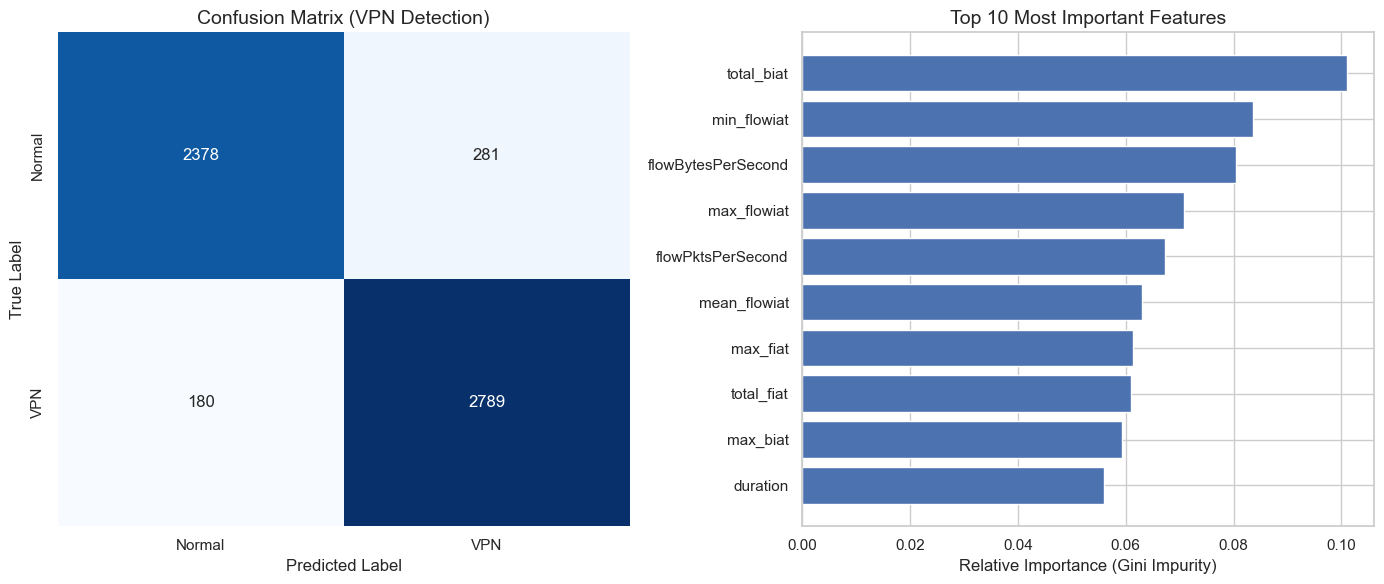

✨ 所有任务已完成！这张图可以直接放到你的报告里。


In [28]:
# ==========================================
# 主程序入口 (Main)
# ==========================================
# 1. 加载
df = load_arff_data(FILE_PATH)

if df is not None:
    # 2. 清洗
    # 如果这里报错 "只有一种类别"，请检查文件名是否包含了完整数据
    X, y = preprocess_data(df)
    
    # 3. 训练
    model, X_test, y_test, y_pred, feat_names = train_and_evaluate(X, y)
    
    # 4. 画图
    visualize_results(model, y_test, y_pred, feat_names)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# ==========================================
# 加分项 1: 多模型对比 (Model Comparison)
# ==========================================
def compare_models(X_train, X_test, y_train, y_test):
    print("\n⚔️ [Bonus 1] 正在进行多模型对比实验...")
    
    models = {
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
    }
    
    plt.figure(figsize=(10, 6))
    
    results = {}
    
    for name, model in models.items():
        # 训练
        model.fit(X_train, y_train)
        
        # 预测概率 (用于画 ROC)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            # 对于没有概率输出的模型，直接用 0/1 (效果会是折线)
            y_prob = model.predict(X_test)
            
        # 计算 ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        results[name] = roc_auc
        
        # 画线
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
        print(f"   -> {name} 训练完成, AUC={roc_auc:.3f}")

    # 画对角线 (随机猜测线)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# ==========================================
# 加分项 2: t-SNE 可视化 (Visualizing Separation)
# ==========================================
def plot_tsne(X, y, sample_size=1000):
    print("\n🎨 [Bonus 2] 正在计算 t-SNE 分布图 (可能需要几十秒)...")
    
    # 为了速度，只随机采样 sample_size 个点来画图
    if len(X) > sample_size:
        indices = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X.iloc[indices]
        y_sample = y.iloc[indices]
    else:
        X_sample = X
        y_sample = y

    # 降维到 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_embedded = tsne.fit_transform(X_sample)
    
    # 画图
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 
                          c=y_sample, cmap='coolwarm', alpha=0.6, s=20)
    
    # 手动添加图例
    legend_handles = [
        mpatches.Patch(color='#6788ee', label='Normal Traffic (0)'), # 蓝色系
        mpatches.Patch(color='#e46c5e', label='VPN Traffic (1)')     # 红色系
    ]
    plt.legend(handles=legend_handles)
    
    plt.title('t-SNE Visualization of Network Traffic Features')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
    print("✨ t-SNE 图表已生成！")
    print("   (解读: 如果红色点和蓝色点分成了两堆，说明特征非常有效；如果混在一起，说明很难区分)")

# ==========================================
# 运行加分模块
# ==========================================
# 只需要用到之前切分好的 X_train 等变量
# 如果你重启了内核，需要重新运行之前的 split 代码
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 重新准备数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. 运行 ROC 对比
compare_models(X_train_scaled, X_test_scaled, y_train, y_test)

# 2. 运行 t-SNE (使用原始 X 或 Scaled 均可，这里用 Scaled)
# 注意：把 dataframe 转换回 numpy array 传入
import pandas as pd
if isinstance(X_train_scaled, pd.DataFrame):
    X_for_tsne = X_train_scaled
else:
    # 如果是 numpy array，构建临时 DataFrame 方便索引
    X_for_tsne = pd.DataFrame(X_train_scaled)

# 传入原始标签序列 (注意 index 对齐)
plot_tsne(X_for_tsne, pd.Series(y_train).reset_index(drop=True))


⚔️ [Bonus 1] 正在进行多模型对比实验...
   -> Decision Tree 训练完成, AUC=0.897


In [ ]:
# 1. 自动检测并安装 xgboost
try:
    import xgboost as xgb
except ImportError:
    print("⚠️ 未检测到 xgboost，正在安装...")
    !pip install xgboost
    import xgboost as xgb

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# ==========================================
# 定义巅峰对决函数
# ==========================================
def advanced_model_comparison(X_train, X_test, y_train, y_test):
    print("\n⚔️ [Final Boss] 正在进行高阶模型对比实验...")
    
    # 定义三大模型
    models = {
        # 1. 基准模型：随机森林
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        
        # 2. 进阶模型：XGBoost (Kaggle之王)
        "XGBoost": xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=42),
        
        # 3. 深度学习：MLP (多层感知机神经网络)
        # 结构：输入层 -> 隐藏层(128) -> 隐藏层(64) -> 输出层
        "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
    }
    
    # 存储结果
    results = []
    
    for name, model in models.items():
        print(f"   -> 正在训练 {name} ...")
        
        # 训练
        model.fit(X_train, y_train)
        
        # 预测
        y_pred = model.predict(X_test)
        
        # 尝试获取概率用于计算 AUC (MLP和RF支持，部分模型需特殊处理)
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_prob)
        except:
            auc = 0.0
            
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1-Score": f1,
            "AUC": auc
        })
    
    # 转为 DataFrame 展示
    res_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
    
    print("\n🏆 最终战绩排行榜 (Leaderboard):")
    return res_df

# ==========================================
# 运行对比
# ==========================================
# 确保使用归一化后的数据 (Neural Network 对缩放非常敏感！)
# 如果变量丢失，重新运行一下 split 和 scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 这里的 X, y 来源于之前的步骤
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 开始跑！
leaderboard = advanced_model_comparison(X_train_scaled, X_test_scaled, y_train, y_test)

# 使用 seaborn 画个漂亮的柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x="F1-Score", y="Model", data=leaderboard, palette="viridis")
plt.title("Model Performance Comparison: F1-Score", fontsize=15)
plt.xlim(0.5, 1.0) # 设置x轴范围，让差异更明显
plt.show()

leaderboard # 打印详细表格

In [ ]:
# 超参数微调
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# ==========================================
# 5. 模型微调 (Hyperparameter Tuning)
# ==========================================
def tune_random_forest(X_train, y_train, X_test, y_test):
    print("\n🔧 [Step 5] 正在对冠军模型 (Random Forest) 进行超参数搜索...")
    print("   (这可能需要 1-2 分钟，请耐心等待...)")
    
    # 1. 定义参数网格 (尝试不同的组合)
    param_grid = {
        'n_estimators': [100, 200],       # 树的数量：多一点通常更好，但更慢
        'max_depth': [None, 20, 30],      # 树的深度：None表示不限制(容易过拟合)，限制一下可能泛化更好
        'min_samples_split': [2, 5, 10],  # 节点分裂门槛：大一点能防止过拟合
        'min_samples_leaf': [1, 2, 4]     # 叶子节点最小样本数
    }
    
    # 2. 初始化网格搜索
    # cv=3: 3折交叉验证
    # scoring='f1': 我们最看重 F1 Score
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=3, n_jobs=-1, verbose=1, scoring='f1')
    
    # 3. 开始搜索 (只在训练集上跑，不能碰测试集！)
    grid_search.fit(X_train, y_train)
    
    # 4. 输出最佳结果
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"\n🎉 搜索完成！")
    print(f"   -> 最佳参数组合: {best_params}")
    print(f"   -> 训练集交叉验证最佳 F1: {best_score:.4f}")
    
    # 5. 【关键】用最佳参数在测试集上通过“期末考试”
    print("\n📝 正在使用最佳参数在测试集 (Test Set) 上进行最终验证...")
    best_rf = grid_search.best_estimator_
    y_pred_final = best_rf.predict(X_test)
    
    final_acc = accuracy_score(y_test, y_pred_final)
    final_f1 = f1_score(y_test, y_pred_final)
    
    print(f"   -> 最终测试集 Accuracy: {final_acc:.4f}")
    print(f"   -> 最终测试集 F1-Score: {final_f1:.4f}")
    
    return best_rf, best_params

# ==========================================
# 运行微调
# ==========================================
# 确保使用之前定义的 X_train_scaled (归一化后的数据)
# 如果你之前的变量名是 X_train, 这里就用 X_train
# 为了保险，我们用 Scaled 版本
if 'X_train_scaled' in globals():
    final_model, best_params = tune_random_forest(X_train_scaled, y_train, X_test_scaled, y_test)
else:
    print("⚠️ 警告: 找不到 X_train_scaled 变量。请先运行上面的 'Advanced Model Comparison' 代码块。")

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================
# 6. 最终大结局：默认模型 vs 微调模型 (5折交叉验证)
# ==========================================
def compare_final_cv(X, y, best_params_dict):
    print("\n⚖️ [Step 6] 正在进行最终对决：默认模型 vs 微调模型 (5-Fold CV)...")
    
    # 1. 定义选手
    # 选手 A: 默认参数 (比较狂野)
    model_default = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    # 选手 B: 微调参数 (比较克制)
    # 使用 **best_params_dict 自动传入你刚才搜到的参数
    model_tuned = RandomForestClassifier(**best_params_dict, random_state=42, n_jobs=-1)
    
    # 2. 定义裁判 (洗牌机制)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 3. 比赛开始
    print("   -> 正在跑默认模型 (Default)...")
    scores_default = cross_val_score(model_default, X, y, cv=cv, scoring='f1', n_jobs=-1)
    
    print("   -> 正在跑微调模型 (Tuned)...")
    scores_tuned = cross_val_score(model_tuned, X, y, cv=cv, scoring='f1', n_jobs=-1)
    
    # 4. 打印战绩
    print("\n🏆 比赛结果 (Mean F1 +/- Std):")
    print(f"   [Default RF]: {scores_default.mean():.4f} (+/- {scores_default.std() * 2:.4f})")
    print(f"   [Tuned   RF]: {scores_tuned.mean():.4f} (+/- {scores_tuned.std() * 2:.4f})")
    
    # 5. 可视化 (箱线图 Boxplot)
    # 箱线图能完美展示分数的“波动范围”
    results_df = pd.DataFrame({
        'Default RF': scores_default,
        'Tuned RF': scores_tuned
    })
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=results_df, palette="Set3", width=0.5)
    sns.stripplot(data=results_df, color=".25", size=5) # 加上散点，增加真实感
    
    plt.title('Cross-Validation Stability Comparison (5-Folds)')
    plt.ylabel('F1 Score')
    plt.ylim(min(scores_default.min(), scores_tuned.min()) - 0.01, 
             max(scores_default.max(), scores_tuned.max()) + 0.005)
    plt.show()

# ==========================================
# 运行
# ==========================================
# 确保你有 best_params 变量 (来自 Step 5)
if 'best_params' in globals():
    compare_final_cv(X, y, best_params)
else:
    print("⚠️ 找不到 best_params。请先运行 Step 5 (GridSearch) 获取最佳参数。")
    # 如果你懒得跑 Step 5，可以手动把参数填在这里测试：
    # manual_params = {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
    # compare_final_cv(X, y, manual_params)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# ==========================================
# 7. 深度优化：Stacking 集成学习
# ==========================================
def train_stacking_model(X_train, y_train, X_test, y_test, rf_params=None):
    print("\n🧱 [Step 7] 正在构建 Stacking 集成模型...")
    
    # 1. 定义基学习器 (Base Learners)
    # 如果之前有搜索到最佳 RF 参数，使用它；否则用默认约束参数
    if rf_params:
        rf_model = RandomForestClassifier(**rf_params, random_state=42, n_jobs=-1)
    else:
        rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
    
    estimators = [
        ('rf', rf_model),
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42))
    ]
    
    # 2. 定义元学习器 (Meta Learner)
    # 负责汇总基学习器的判断，通常使用简单的逻辑回归
    final_estimator = LogisticRegression()
    
    # 3. 构建 Stacking 分类器
    # cv=5: 内部训练使用5折，防止过拟合
    clf_stack = StackingClassifier(
        estimators=estimators, 
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1
    )
    
    # 4. 训练
    print("   -> 正在训练 Stacking 模型 (可能需要几分钟)...")
    clf_stack.fit(X_train, y_train)
    
    # 5. 预测与评估
    y_pred = clf_stack.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"   -> Stacking Model Accuracy: {acc:.4f}")
    print(f"   -> Stacking Model F1-Score: {f1:.4f}")
    
    return clf_stack

# ==========================================
# 运行
# ==========================================
# 确保传入归一化后的数据 (因为包含了 MLP)
if 'X_train_scaled' in globals() and 'best_params' in globals():
    stacking_model = train_stacking_model(X_train_scaled, y_train, X_test_scaled, y_test, best_params)
elif 'X_train_scaled' in globals():
    stacking_model = train_stacking_model(X_train_scaled, y_train, X_test_scaled, y_test)
else:
    print("⚠️ 缺少数据变量 X_train_scaled，请先运行数据预处理和分割步骤。")


🧱 [Step 7] 正在构建 Stacking 集成模型...
   -> 正在训练 Stacking 模型 (可能需要几分钟)...
   -> Stacking Model Accuracy: 0.9222
   -> Stacking Model F1-Score: 0.9274


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# ==========================================
# 8. 进阶优化：RFECV 递归特征消除
# ==========================================
def optimize_features_and_retrain(X_train, y_train, X_test, y_test, best_rf_params=None):
    print("\n✂️ [Step 8] 正在进行 RFECV 特征筛选 (去除冗余特征)...")
    
    # 1. 定义选择器
    # 使用随机森林作为基模型来评估特征重要性
    # step=1: 每次剔除 1 个特征 (追求精度)
    # min_features_to_select=10: 至少保留 10 个特征
    estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5), 
                  scoring='f1', min_features_to_select=10, n_jobs=-1)
    
    # 2. 拟合选择器
    print("   -> 正在递归筛选特征 (这需要一点时间)...")
    rfecv.fit(X_train, y_train)
    
    print(f"   -> 最佳特征数量: {rfecv.n_features_}")
    
    # 打印被剔除的特征 (如果有的话)
    # 假设 X_train 是 DataFrame，如果是 numpy array 则跳过名字打印
    if hasattr(X_train, 'columns'):
        dropped_feats = X_train.columns[~rfecv.support_]
        print(f"   -> 剔除的特征 ({len(dropped_feats)}个): {list(dropped_feats)}")
    
    # 3. 转换数据集 (只保留有用特征)
    X_train_selected = rfecv.transform(X_train)
    X_test_selected = rfecv.transform(X_test)
    
    # 4. 使用精华特征重训练 Stacking 模型
    print("\n🔄 [Retrain] 使用筛选后的特征重训练 Stacking 模型...")
    
    # 重新定义基学习器 (保持之前的配置)
    if best_rf_params:
        rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
    else:
        rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
        
    estimators = [
        ('rf', rf),
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42))
    ]
    
    final_estimator = LogisticRegression()
    
    clf_stack_opt = StackingClassifier(
        estimators=estimators, 
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1
    )
    
    clf_stack_opt.fit(X_train_selected, y_train)
    
    # 5. 最终验证
    y_pred = clf_stack_opt.predict(X_test_selected)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"   -> Optimized Stacking F1-Score: {f1:.4f}")
    
    # 返回筛选后的数据，以便后续使用
    return clf_stack_opt, rfecv, X_train_selected, X_test_selected

# ==========================================
# 运行
# ==========================================
# 这一步必须传入 Pandas DataFrame 格式的 X_train (带有列名)，否则无法打印被删除的特征名
# 如果之前的 X_train_scaled 是 numpy 数组，这里我们尝试用带列名的版本
# 如果报错，请直接传入 X_train_scaled 即可

if 'X_train' in globals() and 'best_params' in globals():
    # 注意：RFECV 最好使用未归一化的原始数据来判断树模型特征，或者归一化后的也可以
    # 这里我们用 Scaled 数据保持一致性，但将其转回 DataFrame 以便看列名
    import pandas as pd
    
    # 尝试恢复列名 (如果 feat_names 存在)
    if 'feat_names' in globals() and not isinstance(X_train_scaled, pd.DataFrame):
        X_train_labeled = pd.DataFrame(X_train_scaled, columns=feat_names)
        X_test_labeled = pd.DataFrame(X_test_scaled, columns=feat_names)
    else:
        X_train_labeled = X_train_scaled
        X_test_labeled = X_test_scaled

    stack_opt, selector, X_train_rfe, X_test_rfe = optimize_features_and_retrain(
        X_train_labeled, y_train, X_test_labeled, y_test, best_params
    )


✂️ [Step 8] 正在进行 RFECV 特征筛选 (去除冗余特征)...
   -> 正在递归筛选特征 (这需要一点时间)...
   -> 最佳特征数量: 16
   -> 剔除的特征 (7个): ['min_active', 'mean_active', 'max_active', 'std_active', 'mean_idle', 'max_idle', 'std_idle']

🔄 [Retrain] 使用筛选后的特征重训练 Stacking 模型...
   -> Optimized Stacking F1-Score: 0.9246
